<a href="https://colab.research.google.com/github/ny147/infant-classification/blob/pete/train_evaluate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import librosa, librosa.display
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
import IPython.display as ipd
import numpy as np
import shutil
#import ftransc

/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


# For Colab

In [3]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/Infant_cry"
train_directory = path + '/mel_spectrogram/train_oneclass/hungry_one'
test_directory = path + '/mel_spectrogram/test_oneclass/hungry_one'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Local 

In [ ]:
# train_directory = path + '/data_matlab/train/'
# test_directory = path + '/data_matlab/test/'

In [4]:



train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='int', image_size=(256, 256), seed=321,
    validation_split=None, subset=None)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory, labels='inferred', label_mode='int', image_size=(256, 256),
    validation_split=None, subset=None)

class_names = train_ds.class_names
print(class_names)

Found 303 files belonging to 2 classes.
Found 154 files belonging to 2 classes.
['hungry', 'non_hungry']


In [5]:
## create model

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.callbacks import ModelCheckpoint

In [7]:
x_train=[]
y_train=[]
for images, labels in train_ds.unbatch().take(-1):
    x_train.append(images.numpy())
    y_train.append(labels.numpy())

In [8]:
x_test=[]
y_test=[]
for images, labels in test_ds.unbatch().take(-1):
    x_test.append(images.numpy())
    y_test.append(labels.numpy())

In [9]:
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [10]:
num_classes = 2
img_height = 256
img_width = 256
def create_weight(n_sample,n_class,n_class_sample):
    weight = n_sample/(n_class*n_class_sample)
    return weight

In [53]:
class_weights = {0:0, 1:0}
class_count = np.array([254,49])
for i in range(num_classes):
    class_weights[i]=create_weight(306,num_classes,class_count[i])

In [220]:
# base_model = tf.keras.applications.Xception(
#     weights="imagenet",  # Load weights pre-trained on ImageNet.
#     input_shape=(img_height, img_width, 3),
#     include_top=False,
# )  # Do not include the ImageNet classifier at the top.

# base_model = tf.keras.applications.ResNet50V2(
#     include_top=False,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=(img_height, img_width, 3),
#     pooling=None,
#     # classes=1000,
#     classifier_activation="softmax",
# )
base_model = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(img_height, img_width, 3),
    pooling=None,
    classifier_activation="softmax"
)
# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
#x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = tf.keras.layers.Rescaling(scale=1./255)
x = scale_layer(inputs)

x = tf.cast(x,tf.float32)
# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
# x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1)(x)
outputs = tf.keras.layers.Activation('sigmoid')(outputs)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 rescaling_30 (Rescaling)    (None, 256, 256, 3)       0         
                                                                 
 tf.cast_12 (TFOpLambda)     (None, 256, 256, 3)       0         
                                                                 
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_12  (None, 1536)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_46 (Dropout)        (None, 1536)              0  

In [230]:
model = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
            tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
            tf.keras.layers.MaxPooling2D((2,2)),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),            
            tf.keras.layers.MaxPooling2D((2,2)),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
            tf.keras.layers.MaxPooling2D((2,2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_32 (Rescaling)    (None, 256, 256, 3)       0         
                                                                 
 conv2d_1088 (Conv2D)        (None, 256, 256, 256)     7168      
                                                                 
 max_pooling2d_82 (MaxPoolin  (None, 128, 128, 256)    0         
 g2D)                                                            
                                                                 
 dropout_49 (Dropout)        (None, 128, 128, 256)     0         
                                                                 
 conv2d_1089 (Conv2D)        (None, 128, 128, 128)     295040    
                                                                 
 max_pooling2d_83 (MaxPoolin  (None, 64, 64, 128)      0         
 g2D)                                                

In [231]:
#resnet 
#inception v3

In [232]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',patience = 15)
earlystop_callback2 = tf.keras.callbacks.EarlyStopping(monitor = 'accuracy',patience = 15)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()# modify weight in Adam
metrics = ['accuracy']
model.compile (optimizer = optimizer,loss =  loss_fn,metrics = metrics)

In [233]:
# Set the epocks
# ทำ stop + validation
epochs = 40
history = model.fit(x_train, y_train, epochs=epochs,validation_split=0.3,class_weight = class_weights,callbacks = [earlystop_callback,earlystop_callback2])

#history = model.fit(x_train, y_train, epochs=epochs,validation_split=0.3)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


7/7 [==============================] - 3s 398ms/step - loss: 1.5252 - accuracy: 0.6038 - val_loss: 0.6994 - val_accuracy: 0.1648
Epoch 2/40
7/7 [==============================] - 3s 365ms/step - loss: 0.6995 - accuracy: 0.1604 - val_loss: 0.6989 - val_accuracy: 0.1648
Epoch 3/40
7/7 [==============================] - 3s 365ms/step - loss: 0.6979 - accuracy: 0.5047 - val_loss: 0.6935 - val_accuracy: 0.3626
Epoch 4/40
7/7 [==============================] - 3s 364ms/step - loss: 0.7528 - accuracy: 0.7170 - val_loss: 0.6948 - val_accuracy: 0.2637
Epoch 5/40
7/7 [==============================] - 3s 364ms/step - loss: 0.6956 - accuracy: 0.3726 - val_loss: 0.6955 - val_accuracy: 0.3297
Epoch 6/40
7/7 [==============================] - 3s 366ms/step - loss: 0.6938 - accuracy: 0.7170 - val_loss: 0.6919 - val_accuracy: 0.4615
Epoch 7/40
7/7 [==============================] - 3s 364ms/step - loss: 0.6805 - accuracy: 0.5991 - val_loss: 0.6488 - val_accuracy: 0.7143
Epoch 8/40
7/7 [===============

In [234]:
earlystop_callback2 = tf.keras.callbacks.EarlyStopping(monitor = 'binary_accuracy',patience = 15)
base_model.trainable = True
model.summary()
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

epochs = 30
history = model.fit(x_train, y_train, epochs=epochs,validation_split=0.3,callbacks = [earlystop_callback,earlystop_callback2],class_weight = class_weights)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_32 (Rescaling)    (None, 256, 256, 3)       0         
                                                                 
 conv2d_1088 (Conv2D)        (None, 256, 256, 256)     7168      
                                                                 
 max_pooling2d_82 (MaxPoolin  (None, 128, 128, 256)    0         
 g2D)                                                            
                                                                 
 dropout_49 (Dropout)        (None, 128, 128, 256)     0         
                                                                 
 conv2d_1089 (Conv2D)        (None, 128, 128, 128)     295040    
                                                                 
 max_pooling2d_83 (MaxPoolin  (None, 64, 64, 128)      0         
 g2D)                                                

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


7/7 [==============================] - 3s 402ms/step - loss: 0.0077 - binary_accuracy: 1.0000 - val_loss: 1.4525 - val_binary_accuracy: 0.7692
Epoch 2/30
7/7 [==============================] - 3s 369ms/step - loss: 0.0081 - binary_accuracy: 1.0000 - val_loss: 1.4310 - val_binary_accuracy: 0.7692
Epoch 3/30
7/7 [==============================] - 3s 370ms/step - loss: 0.0100 - binary_accuracy: 0.9953 - val_loss: 1.4157 - val_binary_accuracy: 0.7802
Epoch 4/30
7/7 [==============================] - 3s 371ms/step - loss: 0.0099 - binary_accuracy: 1.0000 - val_loss: 1.4019 - val_binary_accuracy: 0.7802
Epoch 5/30
7/7 [==============================] - 3s 370ms/step - loss: 0.0069 - binary_accuracy: 1.0000 - val_loss: 1.3933 - val_binary_accuracy: 0.7802
Epoch 6/30
7/7 [==============================] - 3s 369ms/step - loss: 0.0073 - binary_accuracy: 1.0000 - val_loss: 1.3836 - val_binary_accuracy: 0.7802
Epoch 7/30
7/7 [==============================] - 3s 370ms/step - loss: 0.0049 - binary

In [235]:
def binary_transform(pred):
    if pred > 0.5:
        predicted = 1
    else:
        predicted = 0
    return predicted

In [236]:
pred = model.predict(x_test)

vfunc = np.vectorize(binary_transform)
y_pred = vfunc(pred)
actual = x_test

<function matplotlib.pyplot.show>

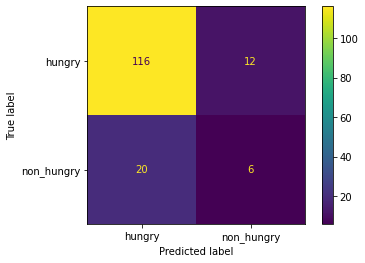

In [237]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot()
plt.show

In [238]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred,target_names=["Hungry","Non_hungry"]))

              precision    recall  f1-score   support

      Hungry       0.85      0.91      0.88       128
  Non_hungry       0.33      0.23      0.27        26

    accuracy                           0.79       154
   macro avg       0.59      0.57      0.58       154
weighted avg       0.77      0.79      0.78       154

